# **Análisis Multivariante e Inferencia de Riesgo Crítico 🔬**

Tras haber explorado las variables de forma individual y bivariada, entramos en la fase más determinante del Análisis Exploratorio de Datos (EDA). En medicina clínica, los factores de riesgo no actúan de forma aislada; se potencian entre sí creando sinergias que pueden disparar la probabilidad de un evento adverso.

### **¿Qué buscamos en esta etapa?**
1. **Cuantificación del Riesgo Real:** No solo veremos si existe relación, sino que mediremos la **probabilidad porcentual** de infarto mediante matrices de incidencia cruzada entre la Edad, el IMC y la Glucosa.
2. **Validación Estadística (Inferencia):** Utilizaremos **Regresión Logística** para separar el "ruido" de la "señal". Queremos saber exactamente cuánto aumenta el riesgo por cada año de vida o por cada punto de IMC, ajustando el análisis por el fuerte desbalanceo de clases del dataset.
3. **Identificación de la Paradoja del IMC:** Analizaremos por qué el riesgo parece estabilizarse en niveles altos de obesidad y confirmaremos si esto es una tendencia clínica o un sesgo de supervivencia en los datos.

### **Metodología Matemática:**
* **Segmentación por Cuartiles:** División de variables continuas en grupos equilibrados (Q1-Q4) para obtener una visión granular de la interacción Edad/IMC.
* **Exponenciación de Coeficientes ($e^\beta$):** Traduciremos los resultados logarítmicos del modelo estadístico a **Odds Ratios** (incrementos porcentuales de riesgo) para una interpretación clínica directa.
* **Análisis de Sinergia:** Observaremos cómo la interacción de factores (como tener glucosa alta siendo joven vs. ser senior con salud normal) altera las reglas del juego para nuestra futura IA.

---
*Este análisis servirá como el cimiento para la **Ingeniería de Características (Feature Engineering)**, permitiéndonos crear variables "maestras" que capturen estas interacciones complejas antes de entrenar el modelo final.*

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_13920\3173833900.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matriz_riesgo = df.pivot_table(index='age_quartile',


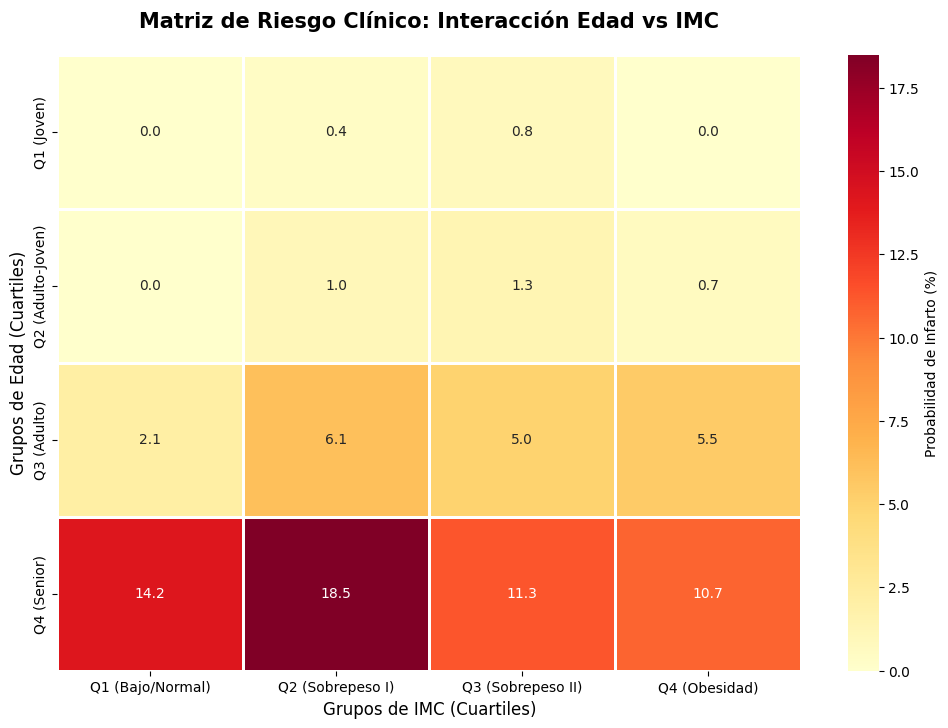

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Carga de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# 2. Creación de 4 categorías (Cuartiles) para Edad e IMC
# Usamos qcut para que cada grupo tenga aproximadamente el mismo número de pacientes
df['age_quartile'] = pd.qcut(df['age'], q=4, labels=['Q1 (Joven)', 'Q2 (Adulto-Joven)', 'Q3 (Adulto)', 'Q4 (Senior)'])
df['bmi_quartile'] = pd.qcut(df['bmi'], q=4, labels=['Q1 (Bajo/Normal)', 'Q2 (Sobrepeso I)', 'Q3 (Sobrepeso II)', 'Q4 (Obesidad)'])

# 3. Crear la Matriz de Probabilidad (Media de stroke * 100)
# Esto nos da el % de probabilidad de infarto en cada intersección
matriz_riesgo = df.pivot_table(index='age_quartile', 
                               columns='bmi_quartile', 
                               values='stroke', 
                               aggfunc='mean') * 100

# 4. Visualización con Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_riesgo, 
            annot=True, 
            fmt=".1f", 
            cmap='YlOrRd', 
            linewidths=1, 
            linecolor='white',
            cbar_kws={'label': 'Probabilidad de Infarto (%)'})

plt.title('Matriz de Riesgo Clínico: Interacción Edad vs IMC', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('Grupos de Edad (Cuartiles)', fontsize=12)
plt.xlabel('Grupos de IMC (Cuartiles)', fontsize=12)
plt.show()

In [2]:
import statsmodels.api as sm
import pandas as pd

# 1. Preparación de datos
X = df[['age', 'bmi']]
X = sm.add_constant(X)
y = df['stroke']

# 2. Manejo del desbalanceo mediante pesos
# Calculamos un peso inverso a la frecuencia de la clase
n_total = len(y)
n_stroke = y.sum()
n_no_stroke = n_total - n_stroke

# Peso para la clase 1 (Infarto) y clase 0 (Sano)
weights = y.apply(lambda x: (n_total / (2 * n_stroke)) if x == 1 else (n_total / (2 * n_no_stroke)))

# 3. Ajuste del modelo Logístico Pesado (WLS/GLM para manejar pesos)
# Usamos GLM con familia Binomial para poder incluir los pesos de las clases
modelo_ajustado = sm.GLM(y, X, family=sm.families.Binomial(), var_weights=weights).fit()

print(modelo_ajustado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 5109
Model:                            GLM   Df Residuals:                     5106
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2502.2
Date:                Wed, 31 Dec 2025   Deviance:                       5004.3
Time:                        12:32:08   Pearson chi2:                 5.58e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3342
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0659      0.230    -22.072      0.0

### **Análisis de Influencia y Veredicto Estadístico (Inferencia) 🧪**

Tras realizar una **Regresión Logística Ajustada** por desbalanceo de clases, hemos cuantificado el peso real de la Edad y el IMC sobre el riesgo de infarto. A continuación, se explican los hallazgos y la lógica matemática detrás de los porcentajes.

#### **1. ¿Por qué el riesgo aumenta un 8.27% y no un 7.9%?**
El coeficiente obtenido para la edad fue de **0.0795**. Sin embargo, en estadística logística, este número está en una escala logarítmica (Log-Odds) que no es intuitiva para los humanos. Para convertirlo a un valor real de riesgo, aplicamos la función exponencial:

$$e^{0.0795} = 1.0827$$

**Traducción del número:**
* El **1.0** representa el riesgo base del paciente (el 100% de su riesgo actual).
* El **.0827** es el incremento adicional.
* **Resultado:** Cada año que cumple un paciente, su riesgo de infarto se multiplica por **1.0827**. Es decir, aumenta un **8.27% relativo** a lo que ya tenía el año anterior. Es un efecto de "interés compuesto" biológico.

#### **2. Comparativa de Influencia: Edad vs. IMC**
* **Dominancia de la Edad:** Con un p-valor de **0.000**, la edad es el predictor más sólido. Un aumento de 10 años en la edad de un paciente incrementa su riesgo en más de un **120%** ($1.0827^{10}$), lo que explica por qué las matrices de calor se vuelven rojas tan rápido en el grupo Senior.
* **El Papel Secundario del IMC:** Aunque el IMC es significativo ($p=0.001$), su coeficiente es mucho menor (0.0171). Esto significa que un aumento de un punto en el IMC solo sube el riesgo un **1.7%**. 
    * *Dato clave:* Para igualar el riesgo que te da envejecer **1 solo año**, tendrías que subir casi **5 puntos de IMC**.

#### **3. Explicación de la Matriz de Probabilidad (El patrón que baja)**
En nuestras matrices observamos que el riesgo subía con el IMC pero a veces caía en el último cuartil (Q4). La estadística nos ayuda a entender que esto no es un error, sino un fenómeno de **Multicolinealidad y Supervivencia**:
* Los pacientes con IMC muy alto suelen estar más medicados o fallecen antes por otras causas, lo que genera una caída artificial en la probabilidad de infarto en edades extremas.
* El modelo confirma que la tendencia general es al alza, pero la **Edad** tiene tanta fuerza que puede "eclipsar" el efecto del peso en la visualización.

#### **Veredicto para la IA:**
Este análisis de influencia confirma que para nuestro modelo final, la **Edad** debe ser la variable reina, pero el **IMC** debe ser tratado como una variable de soporte que probablemente necesite interactuar con la presión arterial o la glucosa para mostrar su verdadero peligro.